# Visualizing categorical data uncertainty with **bootplot**

In this notebook, we demonstrate how **bootplot** can be used to obtain black-box uncertainty visualizations when dealing with categorical data.
We show examples using bar charts and pie charts.

In [1]:
import numpy as np
from bootplot import bootplot
import matplotlib.pyplot as plt

We will use a small toy dataset with 6 ground truth classes and 50 samples.

In [2]:
np.random.seed(1)
n_classes = 6
event_probability = 0.5
data = np.random.binomial(n_classes - 1, event_probability, 50)

We first create basic plots of our data. As a reference, we also plot a bar chart of the true distribution. We can see that our dataset contains an instance of each class. If any of the classes were missing, we could still proceed with the rest of our workflow and visualize uncertainty for available classes, just that we would not be aware of the missing ones.

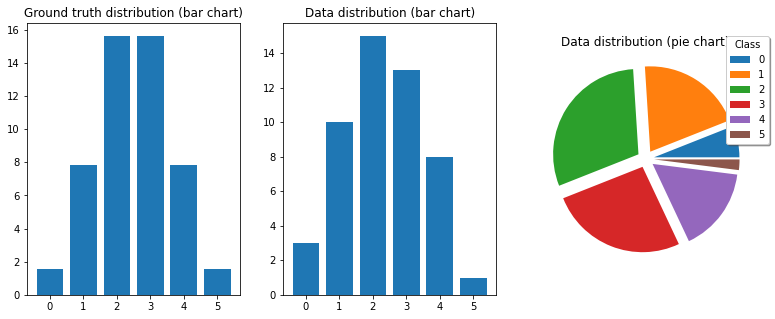

In [3]:
import math


def binomial_pmf(x, n, p):
    return np.array([math.comb(n, x[i]) * (p ** x[i]) * ((1 - p) ** (n - x[i])) for i in range(len(x))])


fig, axes = plt.subplots(1, 3, figsize=(13, 5))

# Ground truth bar chart (showing counts instead of frequencies)
axes[0].set_title('Ground truth distribution (bar chart)')
axes[0].bar(np.arange(n_classes), binomial_pmf(np.arange(n_classes), n_classes - 1, event_probability) * len(data))

# Empirical distribution / dataset bar chart
axes[1].set_title('Data distribution (bar chart)')
labels, counts = np.unique(data, return_counts=True)
axes[1].bar(labels, counts)

# Empirical distribution / dataset pie chart
axes[2].set_title('Data distribution (pie chart)')
wedges, _ = axes[2].pie(counts, explode=0.1 * np.ones(len(labels)))
axes[2].legend(
    wedges,
    list(range(len(labels))),
    loc='upper right',
    bbox_to_anchor=(1.1, 1.1, 0, 0),
    shadow=True,
    title='Class'
)

plt.show()

## Defining the task and the plot function

We wish to find the uncertainty of the class distribution. Since we know how to plot our data, we simply move this code into a plotting function and pass it to **bootplot**. This will make visualizing uncertainty simple. In the pie chart example, it is not easy to visualize uncertainty with error bars, but we can avoid these problems with **bootplot**.

Note that there are minor changes in the pie chart function because a random sample might not always contain all classes. This may cause labels to overlap in the legend because of its implementation in matplotlib. To get around this, we fill the remaining class counts with 0.

In [4]:
def target_distribution_bar_chart(data_subset, data_full, ax):
    ax.bar(*np.unique(data_subset, return_counts=True))
    ax.set_xlim(-1, n_classes)
    ax.set_ylim(0, 25)

In [5]:
def target_distribution_pie_chart(data_subset, data_full, ax):
    # Handle potentially missing classes in the subset
    subset_labels, subset_counts = np.unique(data_subset, return_counts=True)
    values = np.zeros((n_classes,))
    values[subset_labels] = subset_counts

    # Plot the pie chart and its legend
    subset_labels = np.arange(n_classes)
    subset_counts = values

    wedges, _ = ax.pie(x=subset_counts, explode=0.9 * np.ones(len(subset_labels)))

    ax.legend(
        wedges,
        list(range(len(subset_labels))),
        loc='upper right',
        bbox_to_anchor=(1.1, 1.1, 0, 0),
        shadow=True,
        title='Class'
    )

    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)

## Running bootplot

Having defined the plotting functions, we simply pass them to `bootplot` along with the data. In this notebook, we will only work with the returned static images, but we could also save these to disk by specifying `output_image_path` for images and `output_animation_path` for animations. We manually specify `m = 1000` bootstrap samples to make the final result a bit smoother.

In [6]:
bar_chart_image = bootplot(target_distribution_bar_chart, data)

In [7]:
pie_chart_image = bootplot(target_distribution_pie_chart, data, m=1000)

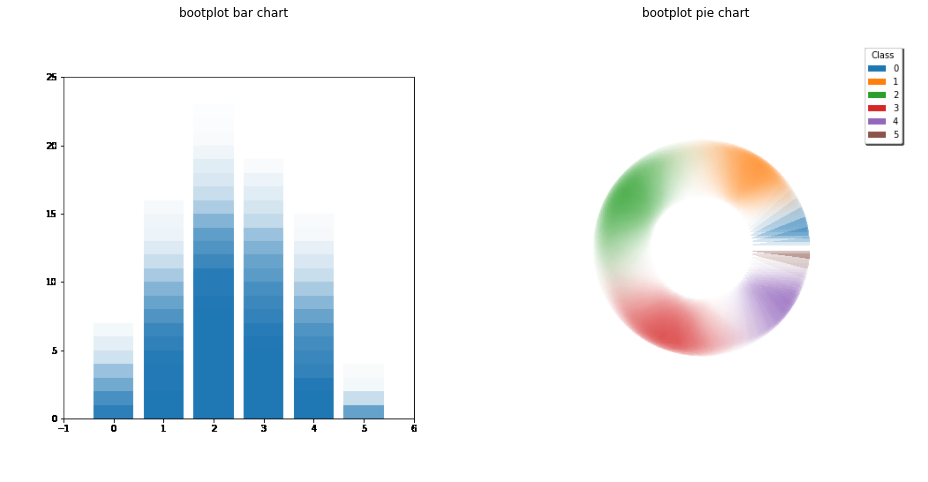

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(13, 7))

axes[0].imshow(bar_chart_image)
axes[0].axis('off')
axes[0].set_title('bootplot bar chart')
axes[1].imshow(pie_chart_image)
axes[1].axis('off')
axes[1].set_title('bootplot pie chart')
fig.tight_layout()

plt.show()

We see that **bootplot** yields good uncertainty visualizations. We can further check that the obtained bar chart is consistent with the ground truth bar chart above by including ground truth values in the plotting function. We see below that the orange ground truth points are reasonably within the shaded bar areas.

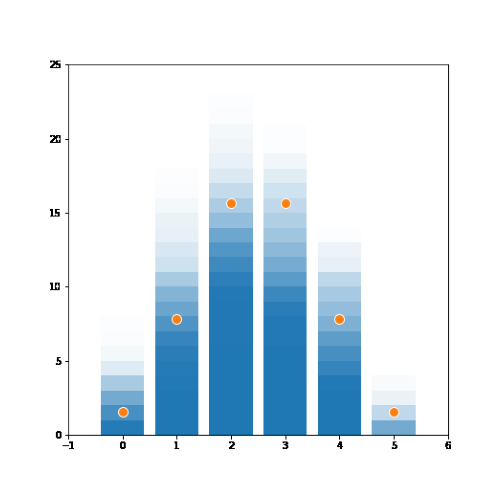

In [9]:
def target_distribution_bar_chart_with_ground_truth(data_subset, data_full, ax):
    ax.bar(*np.unique(data_subset, return_counts=True))
    ax.scatter(np.arange(n_classes), binomial_pmf(np.arange(n_classes), n_classes - 1, event_probability) * len(data), color='tab:orange', edgecolor='white', s=100)
    ax.set_xlim(-1, n_classes)
    ax.set_ylim(0, 25)

bar_chart_image_with_ground_truth = bootplot(target_distribution_bar_chart_with_ground_truth, data)

plt.figure(figsize=(9, 9))
plt.imshow(bar_chart_image_with_ground_truth)
plt.axis('off')
plt.show()